Job Recomendation Using Knowledge Graph

In [197]:
import pandas as pd
import numpy as np


In [198]:
dataset = pd.read_csv("Resume_Dataset/survey_results_public.csv")

C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\2165978649.py:1: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("Resume_Dataset/survey_results_public.csv")


In [199]:
resume_subset= dataset[['Respondent','Country','Student','CompanySize','Dependents','DevType','Gender','JobSatisfaction','LastNewJob','Salary','SalaryType','LanguageWorkedWith','LanguageDesireNextYear','DatabaseWorkedWith','DatabaseDesireNextYear','PlatformWorkedWith','PlatformDesireNextYear','FrameworkWorkedWith','FrameworkDesireNextYear','OperatingSystem','HypotheticalTools1','Age']]
df = pd.DataFrame(resume_subset)
df

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
0,1,Kenya,No,20 to 99 employees,Yes,Full-stack developer,Male,Extremely satisfied,Less than a year ago,NaN,...,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Linux-based,Extremely interested,25 - 34 years old
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
2,4,United States,No,20 to 99 employees,NaN,Engineering manager;Full-stack developer,NaN,Moderately satisfied,Less than a year ago,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,United States,No,100 to 499 employees,No,Full-stack developer,Male,Neither satisfied nor dissatisfied,Less than a year ago,NaN,...,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Azure,Azure,NaN,Angular;.NET Core;React,Windows,Somewhat interested,35 - 44 years old
4,7,South Africa,"Yes, part-time","10,000 or more employees",Yes,Data or business analyst;Desktop or enterprise...,Male,Slightly satisfied,Between 1 and 2 years ago,260000,...,Assembly;C;C++;Matlab;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2,Arduino;Windows Desktop or Server,Arduino;Windows Desktop or Server,NaN,NaN,Windows,Extremely interested,18 - 24 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98850,101513,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98851,101531,Spain,"Yes, full-time",NaN,NaN,Back-end developer;Front-end developer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98852,101541,India,"Yes, full-time",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98853,101544,Russian Federation,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
df1 = df.dropna()
df1

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
17,27,Sweden,No,10 to 19 employees,Yes,Back-end developer,Male,Moderately satisfied,Between 1 and 2 years ago,32000,...,C#;F#;Haskell;SQL;Ocaml,SQL Server,Redis;SQL Server;PostgreSQL;Elasticsearch,Linux;Windows Desktop or Server,Linux;Windows Desktop or Server,.NET Core,.NET Core,Windows,Not at all interested,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,120000,...,C;C++;Go;Python;SQL;Swift;Kotlin,Redis;PostgreSQL;SQLite,Redis;PostgreSQL;SQLite;Google BigQuery,Android;AWS;iOS;Linux;Mac OS;Firebase,Android;AWS;Google Cloud Platform/App Engine;i...,Angular;Node.js,Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,25,...,C#;JavaScript;PHP;SQL;HTML;CSS,MySQL,SQL Server;MySQL,Linux;Mac OS;Windows Desktop or Server,Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old
24,39,India,No,100 to 499 employees,No,Mobile developer,Female;Male,Moderately satisfied,Between 1 and 2 years ago,700000,...,Java;JavaScript;Swift;Kotlin,SQL Server;MySQL,MySQL,Android;iOS;Firebase,Android;iOS;Firebase,Angular;Cordova,Cordova,MacOS,Somewhat interested,25 - 34 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71503,101558,Germany,No,20 to 99 employees,No,Full-stack developer,Male,Slightly dissatisfied,Less than a year ago,50000,...,Ruby;Rust;Swift;HTML;CSS;Bash/Shell,MongoDB;Redis;MySQL;PostgreSQL;Microsoft Azure...,Redis;PostgreSQL;Elasticsearch,AWS;Azure;Heroku;iOS;Mac OS;SharePoint,Heroku;iOS;Mac OS,Angular;.NET Core;Cordova,React,MacOS,A little bit interested,25 - 34 years old
71504,101559,Italy,No,100 to 499 employees,No,Front-end developer;Game or graphics developer...,Male,Moderately satisfied,Less than a year ago,25000,...,C;C++;Java;JavaScript;TypeScript;VB.NET;HTML;CSS,MySQL;PostgreSQL,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;iOS;Windows Phone,Gaming console;iOS;Raspberry Pi;Windows Deskto...,Angular;Cordova,Hadoop;Node.js;React;Xamarin,Windows,Somewhat interested,25 - 34 years old
71510,101567,Australia,"Yes, full-time","10,000 or more employees",No,Back-end developer,Male,Moderately satisfied,Between 1 and 2 years ago,140000,...,Java;JavaScript;Python;Ruby;TypeScript;Kotlin,MySQL;PostgreSQL;Amazon DynamoDB;Amazon Redshi...,Amazon DynamoDB,Amazon Echo;Android,Amazon Echo,Node.js;React;Spring,Spring,MacOS,Extremely interested,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,165000,...,Clojure;R,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,Redis;PostgreSQL,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Linux,Django;Node.js;React;TensorFlow;Torch/PyTorch,Django;React;TensorFlow;Torch/PyTorch,MacOS,Not at all interested,35 - 44 years old


In [201]:
jd = pd.read_csv("Job Description Dataset/dice_com-job_us_sample.csv")

In [202]:
resume_subset.isna().sum()

Respondent                     0
Country                      412
Student                     3954
CompanySize                27324
Dependents                 36259
DevType                     6757
Gender                     34386
JobSatisfaction            29579
LastNewJob                 19966
Salary                     48277
SalaryType                 47785
LanguageWorkedWith         20521
LanguageDesireNextYear     25611
DatabaseWorkedWith         32585
DatabaseDesireNextYear     41357
PlatformWorkedWith         32856
PlatformDesireNextYear     37502
FrameworkWorkedWith        47235
FrameworkDesireNextYear    43637
OperatingSystem            22676
HypotheticalTools1         28787
Age                        34281
dtype: int64

In [203]:
resume_subset.describe()

,Respondent
count,98855.000000
mean,50822.971635
std,29321.650410
min,1.000000
25%,25443.500000
50%,50823.000000
75%,76219.500000
max,101592.000000


In [204]:
dataset.columns

Index(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType',
       ...
       'Exercise', 'Gender', 'SexualOrientation', 'EducationParents',
       'RaceEthnicity', 'Age', 'Dependents', 'MilitaryUS', 'SurveyTooLong',
       'SurveyEasy'],
      dtype='object', length=129)

In [205]:
resume_subset= dataset[['Respondent','Country','Student','CompanySize','Dependents','DevType','Gender','JobSatisfaction','LastNewJob','Salary','SalaryType','LanguageWorkedWith','LanguageDesireNextYear','DatabaseWorkedWith','DatabaseDesireNextYear','PlatformWorkedWith','PlatformDesireNextYear','FrameworkWorkedWith','FrameworkDesireNextYear','OperatingSystem','HypotheticalTools1','Age']]
resume_subset

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
0,1,Kenya,No,20 to 99 employees,Yes,Full-stack developer,Male,Extremely satisfied,Less than a year ago,NaN,...,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Django;React,Django;React,Linux-based,Extremely interested,25 - 34 years old
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
2,4,United States,No,20 to 99 employees,NaN,Engineering manager;Full-stack developer,NaN,Moderately satisfied,Less than a year ago,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,United States,No,100 to 499 employees,No,Full-stack developer,Male,Neither satisfied nor dissatisfied,Less than a year ago,NaN,...,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Azure,Azure,NaN,Angular;.NET Core;React,Windows,Somewhat interested,35 - 44 years old
4,7,South Africa,"Yes, part-time","10,000 or more employees",Yes,Data or business analyst;Desktop or enterprise...,Male,Slightly satisfied,Between 1 and 2 years ago,260000,...,Assembly;C;C++;Matlab;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2,Arduino;Windows Desktop or Server,Arduino;Windows Desktop or Server,NaN,NaN,Windows,Extremely interested,18 - 24 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98850,101513,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98851,101531,Spain,"Yes, full-time",NaN,NaN,Back-end developer;Front-end developer,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98852,101541,India,"Yes, full-time",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98853,101544,Russian Federation,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
resume_subset.dtypes

Respondent                  int64
Country                    object
Student                    object
CompanySize                object
Dependents                 object
DevType                    object
Gender                     object
JobSatisfaction            object
LastNewJob                 object
Salary                     object
SalaryType                 object
LanguageWorkedWith         object
LanguageDesireNextYear     object
DatabaseWorkedWith         object
DatabaseDesireNextYear     object
PlatformWorkedWith         object
PlatformDesireNextYear     object
FrameworkWorkedWith        object
FrameworkDesireNextYear    object
OperatingSystem            object
HypotheticalTools1         object
Age                        object
dtype: object

In [207]:
Resume= resume_subset.dropna()
Resume

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
17,27,Sweden,No,10 to 19 employees,Yes,Back-end developer,Male,Moderately satisfied,Between 1 and 2 years ago,32000,...,C#;F#;Haskell;SQL;Ocaml,SQL Server,Redis;SQL Server;PostgreSQL;Elasticsearch,Linux;Windows Desktop or Server,Linux;Windows Desktop or Server,.NET Core,.NET Core,Windows,Not at all interested,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,120000,...,C;C++;Go;Python;SQL;Swift;Kotlin,Redis;PostgreSQL;SQLite,Redis;PostgreSQL;SQLite;Google BigQuery,Android;AWS;iOS;Linux;Mac OS;Firebase,Android;AWS;Google Cloud Platform/App Engine;i...,Angular;Node.js,Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,25,...,C#;JavaScript;PHP;SQL;HTML;CSS,MySQL,SQL Server;MySQL,Linux;Mac OS;Windows Desktop or Server,Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old
24,39,India,No,100 to 499 employees,No,Mobile developer,Female;Male,Moderately satisfied,Between 1 and 2 years ago,700000,...,Java;JavaScript;Swift;Kotlin,SQL Server;MySQL,MySQL,Android;iOS;Firebase,Android;iOS;Firebase,Angular;Cordova,Cordova,MacOS,Somewhat interested,25 - 34 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71503,101558,Germany,No,20 to 99 employees,No,Full-stack developer,Male,Slightly dissatisfied,Less than a year ago,50000,...,Ruby;Rust;Swift;HTML;CSS;Bash/Shell,MongoDB;Redis;MySQL;PostgreSQL;Microsoft Azure...,Redis;PostgreSQL;Elasticsearch,AWS;Azure;Heroku;iOS;Mac OS;SharePoint,Heroku;iOS;Mac OS,Angular;.NET Core;Cordova,React,MacOS,A little bit interested,25 - 34 years old
71504,101559,Italy,No,100 to 499 employees,No,Front-end developer;Game or graphics developer...,Male,Moderately satisfied,Less than a year ago,25000,...,C;C++;Java;JavaScript;TypeScript;VB.NET;HTML;CSS,MySQL;PostgreSQL,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;iOS;Windows Phone,Gaming console;iOS;Raspberry Pi;Windows Deskto...,Angular;Cordova,Hadoop;Node.js;React;Xamarin,Windows,Somewhat interested,25 - 34 years old
71510,101567,Australia,"Yes, full-time","10,000 or more employees",No,Back-end developer,Male,Moderately satisfied,Between 1 and 2 years ago,140000,...,Java;JavaScript;Python;Ruby;TypeScript;Kotlin,MySQL;PostgreSQL;Amazon DynamoDB;Amazon Redshi...,Amazon DynamoDB,Amazon Echo;Android,Amazon Echo,Node.js;React;Spring,Spring,MacOS,Extremely interested,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,165000,...,Clojure;R,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,Redis;PostgreSQL,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Linux,Django;Node.js;React;TensorFlow;Torch/PyTorch,Django;React;TensorFlow;Torch/PyTorch,MacOS,Not at all interested,35 - 44 years old


array([[<AxesSubplot:title={'center':'Respondent'}>]], dtype=object)

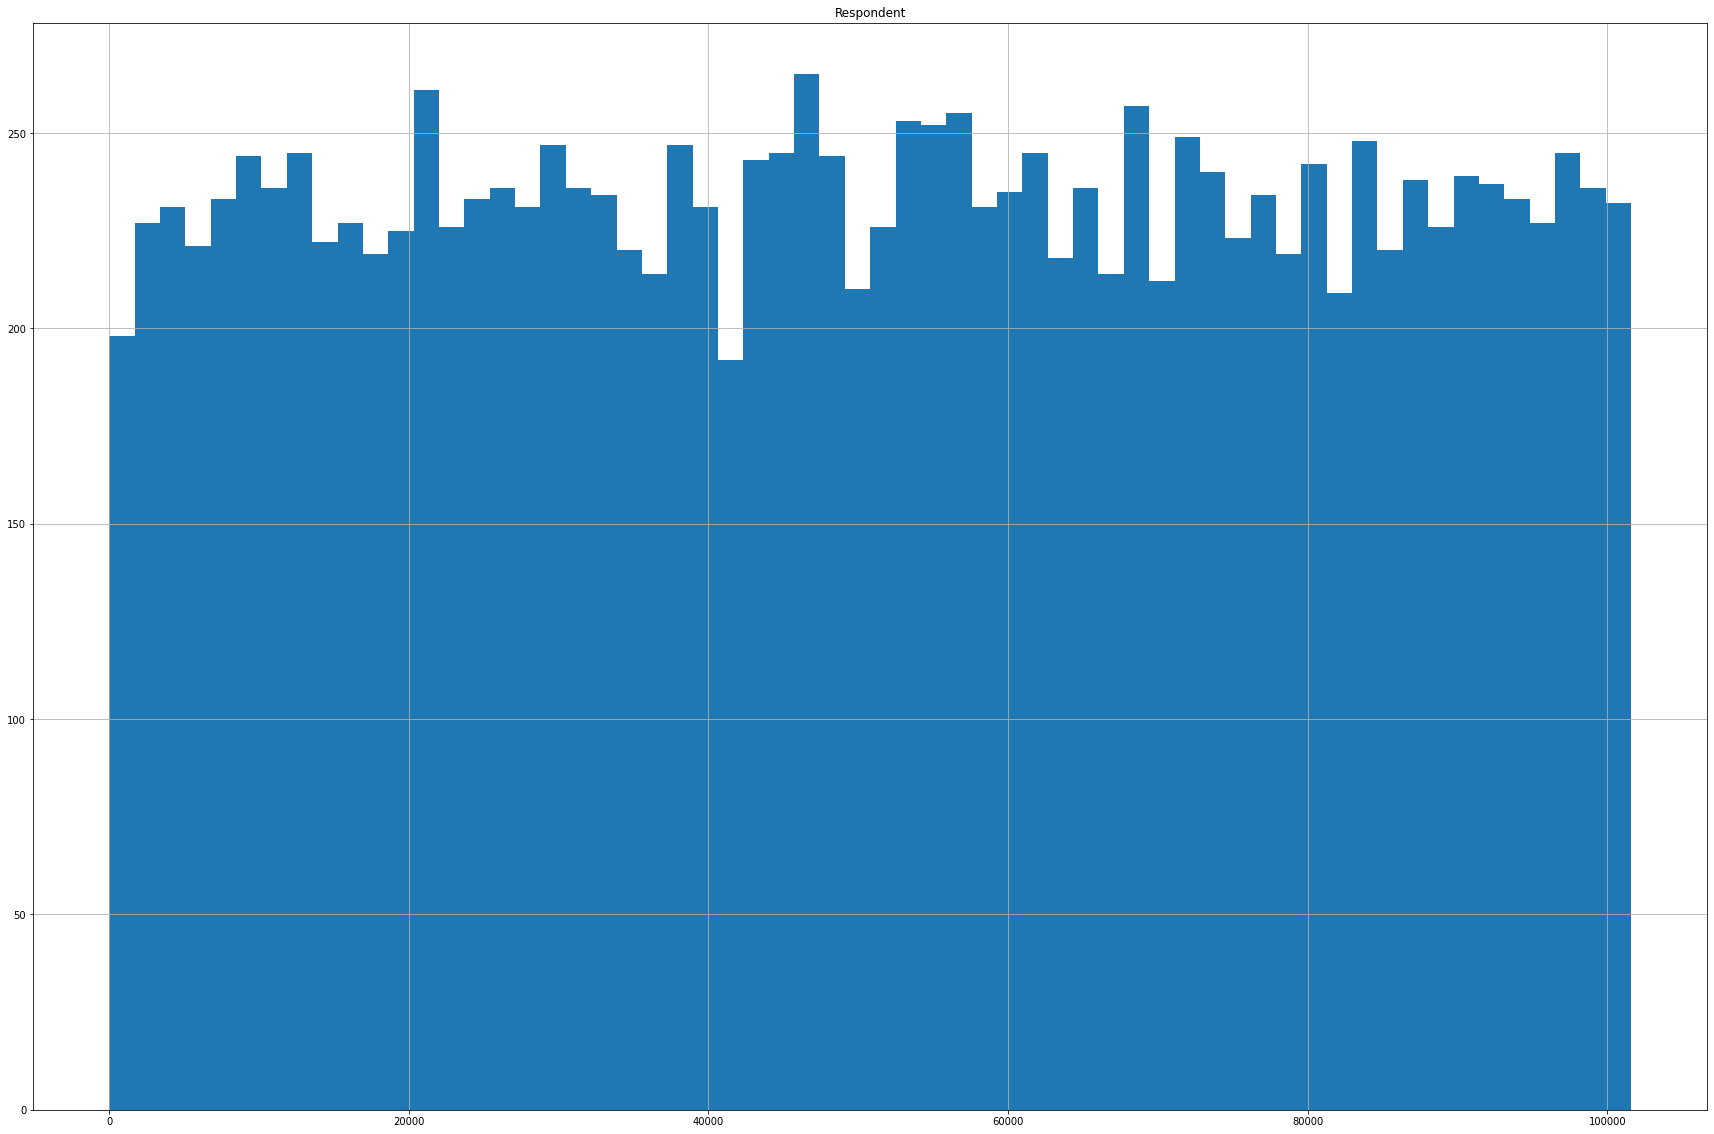

In [208]:
Resume.hist(bins=60, figsize=(30,20))

In [209]:
Resume['DevType'].value_counts()

Full-stack developer                                                                                                                                                                                                                                    1111
Back-end developer;Front-end developer;Full-stack developer                                                                                                                                                                                              981
Back-end developer                                                                                                                                                                                                                                       914
Back-end developer;Full-stack developer                                                                                                                                                                                                          

In [210]:
Devtype_value= Resume['DevType'].value_counts()
Resume2= Resume[~Resume['DevType'].isin(Devtype_value[Devtype_value>100].index)]
Resume2

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,120000,...,C;C++;Go;Python;SQL;Swift;Kotlin,Redis;PostgreSQL;SQLite,Redis;PostgreSQL;SQLite;Google BigQuery,Android;AWS;iOS;Linux;Mac OS;Firebase,Android;AWS;Google Cloud Platform/App Engine;i...,Angular;Node.js,Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,25,...,C#;JavaScript;PHP;SQL;HTML;CSS,MySQL,SQL Server;MySQL,Linux;Mac OS;Windows Desktop or Server,Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old
30,47,Poland,No,20 to 99 employees,No,Back-end developer;Engineering manager,Male,Slightly satisfied,Less than a year ago,8500,...,Erlang;Go;JavaScript;Rust,MongoDB;Redis;MySQL;PostgreSQL,Memcached;Elasticsearch,Linux,Heroku;Raspberry Pi,Django,React;TensorFlow,Linux-based,Not at all interested,25 - 34 years old
53,81,Germany,No,100 to 499 employees,Yes,Back-end developer;Desktop or enterprise appli...,Male,Moderately satisfied,Less than a year ago,5000,...,C;C++;C#;Hack;Java;VB.NET,MySQL;MariaDB,Amazon Redshift;Amazon RDS/Aurora;Google BigQu...,AWS;Linux;Windows Desktop or Server,AWS;Linux;Windows Desktop or Server,Spring,.NET Core,Windows,A little bit interested,35 - 44 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,101551,India,No,Fewer than 10 employees,No,Back-end developer;Front-end developer;Mobile ...,Male,Slightly dissatisfied,Less than a year ago,1500,...,Objective-C,SQL Server;MySQL;PostgreSQL,MongoDB;Amazon DynamoDB;Amazon RDS/Aurora;Micr...,Android;Arduino;AWS;Linux;WordPress;Firebase,Google Cloud Platform/App Engine;IBM Cloud or ...,Angular;Node.js;Cordova,Hadoop;React;Spring,Linux-based,Extremely interested,18 - 24 years old
71502,101557,United States,"Yes, full-time","5,000 to 9,999 employees",No,QA or test developer,Male,Slightly satisfied,Less than a year ago,500,...,Groovy;Haskell;Java;JavaScript;Python;HTML;CSS...,MongoDB;MySQL;PostgreSQL;Oracle,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;Arduino;ESP8266;Heroku;Firebase,Amazon Echo;Android;Arduino;AWS;Azure;ESP8266;...,Node.js;React;TensorFlow,Node.js;React,Windows,Somewhat interested,18 - 24 years old
71504,101559,Italy,No,100 to 499 employees,No,Front-end developer;Game or graphics developer...,Male,Moderately satisfied,Less than a year ago,25000,...,C;C++;Java;JavaScript;TypeScript;VB.NET;HTML;CSS,MySQL;PostgreSQL,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;iOS;Windows Phone,Gaming console;iOS;Raspberry Pi;Windows Deskto...,Angular;Cordova,Hadoop;Node.js;React;Xamarin,Windows,Somewhat interested,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,165000,...,Clojure;R,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,Redis;PostgreSQL,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Linux,Django;Node.js;React;TensorFlow;Torch/PyTorch,Django;React;TensorFlow;Torch/PyTorch,MacOS,Not at all interested,35 - 44 years old


In [211]:
Resume2['Age'].value_counts()

25 - 34 years old     4359
18 - 24 years old     1784
35 - 44 years old     1555
45 - 54 years old      333
55 - 64 years old       77
Under 18 years old      15
65 years or older        2
Name: Age, dtype: int64

In [212]:
Resume2['OperatingSystem'].value_counts()

Windows        4056
MacOS          2321
Linux-based    1740
BSD/Unix          8
Name: OperatingSystem, dtype: int64

In [213]:
location= Resume2['Country'].value_counts()
location[location>50].sum()

7051

In [214]:
Resume3= Resume2[Resume2['Country'].isin(location[location>50].index)]
Resume3

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,...,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,120000,...,C;C++;Go;Python;SQL;Swift;Kotlin,Redis;PostgreSQL;SQLite,Redis;PostgreSQL;SQLite;Google BigQuery,Android;AWS;iOS;Linux;Mac OS;Firebase,Android;AWS;Google Cloud Platform/App Engine;i...,Angular;Node.js,Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,25,...,C#;JavaScript;PHP;SQL;HTML;CSS,MySQL,SQL Server;MySQL,Linux;Mac OS;Windows Desktop or Server,Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old
30,47,Poland,No,20 to 99 employees,No,Back-end developer;Engineering manager,Male,Slightly satisfied,Less than a year ago,8500,...,Erlang;Go;JavaScript;Rust,MongoDB;Redis;MySQL;PostgreSQL,Memcached;Elasticsearch,Linux,Heroku;Raspberry Pi,Django,React;TensorFlow,Linux-based,Not at all interested,25 - 34 years old
53,81,Germany,No,100 to 499 employees,Yes,Back-end developer;Desktop or enterprise appli...,Male,Moderately satisfied,Less than a year ago,5000,...,C;C++;C#;Hack;Java;VB.NET,MySQL;MariaDB,Amazon Redshift;Amazon RDS/Aurora;Google BigQu...,AWS;Linux;Windows Desktop or Server,AWS;Linux;Windows Desktop or Server,Spring,.NET Core,Windows,A little bit interested,35 - 44 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,101551,India,No,Fewer than 10 employees,No,Back-end developer;Front-end developer;Mobile ...,Male,Slightly dissatisfied,Less than a year ago,1500,...,Objective-C,SQL Server;MySQL;PostgreSQL,MongoDB;Amazon DynamoDB;Amazon RDS/Aurora;Micr...,Android;Arduino;AWS;Linux;WordPress;Firebase,Google Cloud Platform/App Engine;IBM Cloud or ...,Angular;Node.js;Cordova,Hadoop;React;Spring,Linux-based,Extremely interested,18 - 24 years old
71502,101557,United States,"Yes, full-time","5,000 to 9,999 employees",No,QA or test developer,Male,Slightly satisfied,Less than a year ago,500,...,Groovy;Haskell;Java;JavaScript;Python;HTML;CSS...,MongoDB;MySQL;PostgreSQL;Oracle,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;Arduino;ESP8266;Heroku;Firebase,Amazon Echo;Android;Arduino;AWS;Azure;ESP8266;...,Node.js;React;TensorFlow,Node.js;React,Windows,Somewhat interested,18 - 24 years old
71504,101559,Italy,No,100 to 499 employees,No,Front-end developer;Game or graphics developer...,Male,Moderately satisfied,Less than a year ago,25000,...,C;C++;Java;JavaScript;TypeScript;VB.NET;HTML;CSS,MySQL;PostgreSQL,MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,Android;iOS;Windows Phone,Gaming console;iOS;Raspberry Pi;Windows Deskto...,Angular;Cordova,Hadoop;Node.js;React;Xamarin,Windows,Somewhat interested,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,165000,...,Clojure;R,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,Redis;PostgreSQL,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Linux,Django;Node.js;React;TensorFlow;Torch/PyTorch,Django;React;TensorFlow;Torch/PyTorch,MacOS,Not at all interested,35 - 44 years old


In [215]:
gender_value=Resume3.groupby('Gender')['Gender'].agg('count').sort_values(ascending=False)
print(gender_value)

Gender
Male                                                                         6652
Female                                                                        292
Non-binary, genderqueer, or gender non-conforming                              29
Male;Non-binary, genderqueer, or gender non-conforming                         19
Female;Transgender                                                             15
Female;Male                                                                     8
Female;Non-binary, genderqueer, or gender non-conforming                        8
Transgender                                                                     8
Transgender;Non-binary, genderqueer, or gender non-conforming                   7
Male;Transgender                                                                6
Female;Male;Transgender                                                         3
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming       2
Female;Ma

// note to muskan
rather hme male,female and other aise 3 categories banani h
so we should be replacing every value in row with these 3 values

In [216]:
gender_less_than_40= gender_value[gender_value<40]
gender_less_than_40

Gender
Non-binary, genderqueer, or gender non-conforming                            29
Male;Non-binary, genderqueer, or gender non-conforming                       19
Female;Transgender                                                           15
Female;Male                                                                   8
Female;Non-binary, genderqueer, or gender non-conforming                      8
Transgender                                                                   8
Transgender;Non-binary, genderqueer, or gender non-conforming                 7
Male;Transgender                                                              6
Female;Male;Transgender                                                       3
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming     2
Female;Male;Non-binary, genderqueer, or gender non-conforming                 1
Female;Transgender;Non-binary, genderqueer, or gender non-conforming          1
Name: Gender, dtype: int64

In [217]:
Resume3.Gender= Resume3.Gender.apply(lambda x: 'other' if x in gender_less_than_40 else x)
len(Resume3.Gender.unique())

C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\1090447623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3.Gender= Resume3.Gender.apply(lambda x: 'other' if x in gender_less_than_40 else x)


3

In [218]:
index_no = Resume3.columns.get_loc('LanguageWorkedWith')
index_no

11

In [219]:
Resume3['LanguageWorkedWith'] = Resume3['LanguageWorkedWith'].str.replace(';',',')
Resume3['PlatformWorkedWith'] = Resume3['PlatformWorkedWith'].str.replace(';',',')
Resume3['DatabaseWorkedWith'] = Resume3['DatabaseWorkedWith'].str.replace(';',',')
Resume3['FrameworkWorkedWith'] = Resume3['FrameworkWorkedWith'].str.replace(';',',')

C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\2015081233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['LanguageWorkedWith'] = Resume3['LanguageWorkedWith'].str.replace(';',',')
C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\2015081233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['PlatformWorkedWith'] = Resume3['PlatformWorkedWith'].str.replace(';',',')
C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\2015081233.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [220]:
Resume3['skills'] = Resume3[[Resume3.columns[10],Resume3.columns[12],Resume3.columns[14],Resume3.columns[16]]].values.tolist()
Resume3['skills']

C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\1684885520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['skills'] = Resume3[[Resume3.columns[10],Resume3.columns[12],Resume3.columns[14],Resume3.columns[16]]].values.tolist()


1                   [Yearly, Go;Python, PostgreSQL, Linux]
20       [Yearly, C;C++;Go;Python;SQL;Swift;Kotlin, Red...
22       [Monthly, C#;JavaScript;PHP;SQL;HTML;CSS, SQL ...
30       [Monthly, Erlang;Go;JavaScript;Rust, Memcached...
53       [Monthly, C;C++;C#;Hack;Java;VB.NET, Amazon Re...
                               ...                        
71497    [Monthly, Objective-C, MongoDB;Amazon DynamoDB...
71502    [Monthly, Groovy;Haskell;Java;JavaScript;Pytho...
71504    [Yearly, C;C++;Java;JavaScript;TypeScript;VB.N...
71524         [Yearly, Clojure;R, Redis;PostgreSQL, Linux]
71526      [Yearly, Python;Kotlin, Cassandra, Amazon Echo]
Name: skills, Length: 7051, dtype: object

In [221]:
Resume3.iloc[0]['skills']

['Yearly', 'Go;Python', 'PostgreSQL', 'Linux']

In [222]:
for index,data in Resume3.iterrows():
    arryOfSkills=data['skills']
    megaskillslist=[]
    for skillStr in arryOfSkills:
        splitEachStr=skillStr.split(',')
        megaskillslist.extend(splitEachStr)
    
    for i in range (len(megaskillslist)):
        megaskillslist[i]= megaskillslist[i].lower()
    unique_list = (list(set(megaskillslist)))
    Resume3.at[index,'skills']=unique_list
Resume3.iloc[0]['skills']

['linux', 'go;python', 'yearly', 'postgresql']

In [223]:
Resume3['Dependents'].value_counts()

No     4779
Yes    2272
Name: Dependents, dtype: int64

In [224]:
Resume3['Student'].value_counts()

No                5607
Yes, full-time     813
Yes, part-time     631
Name: Student, dtype: int64

In [225]:
Country_count=Resume3['Country'].unique()
len(Country_count)

33

In [ ]:
Salary_count= Resume3['Salary'].value_counts()
type(Resume3['Salary'])
Salary_count.describe()

count    1174.000000
mean        6.931857
std        19.036075
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max       181.000000
Name: Salary, dtype: float64

In [226]:
Resume3['SalaryType'].value_counts()

Yearly     4000
Monthly    2879
Weekly      172
Name: SalaryType, dtype: int64

In [227]:
Resume3['Salary']=Resume3['Salary'].str.replace(',','')
Resume3['Salary']

C:\Users\Amit\AppData\Local\Temp\ipykernel_13852\3608720425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resume3['Salary']=Resume3['Salary'].str.replace(',','')


1           51000
20         120000
22             25
30           8500
53           5000
           ...   
71497        1500
71502         500
71504       25000
71524      165000
71526    80000.00
Name: Salary, Length: 7051, dtype: object

In [228]:
def salary_to_monthly(x,y):
    sal = x
    typ= y
#     try:
    #print("run")
    if (typ=="Yearly"):
        #print(typ)
        return (float(sal)/12)
    if (typ=="Weekly"):
        return (float(sal)*4)
    if (typ=="Monthly"):
        return (float(sal))    
#     except:
#         return None


In [233]:
Resume4= Resume3.copy()
# Salary conversion

#print(salary, salarytype)
for index,data in Resume4.iterrows():
    Resume4.at[index,'Salary'] = salary_to_monthly(Resume4.at[index,'Salary'],Resume4.at[index,'SalaryType'])

Resume4.head()


,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,4250.0,...,"Redis,PostgreSQL,Memcached",PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old,"[linux, go;python, yearly, postgresql]"
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,10000.0,...,"Redis,PostgreSQL,SQLite",Redis;PostgreSQL;SQLite;Google BigQuery,"Android,AWS,iOS,Linux,Mac OS,Firebase",Android;AWS;Google Cloud Platform/App Engine;i...,"Angular,Node.js",Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old,"[c;c++;go;python;sql;swift;kotlin, yearly, and..."
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,25.0,...,MySQL,SQL Server;MySQL,"Linux,Mac OS,Windows Desktop or Server",Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old,"[linux;mac os;windows desktop or server, month..."
30,47,Poland,No,20 to 99 employees,No,Back-end developer;Engineering manager,Male,Slightly satisfied,Less than a year ago,8500.0,...,"MongoDB,Redis,MySQL,PostgreSQL",Memcached;Elasticsearch,Linux,Heroku;Raspberry Pi,Django,React;TensorFlow,Linux-based,Not at all interested,25 - 34 years old,"[heroku;raspberry pi, memcached;elasticsearch,..."
53,81,Germany,No,100 to 499 employees,Yes,Back-end developer;Desktop or enterprise appli...,Male,Moderately satisfied,Less than a year ago,5000.0,...,"MySQL,MariaDB",Amazon Redshift;Amazon RDS/Aurora;Google BigQu...,"AWS,Linux,Windows Desktop or Server",AWS;Linux;Windows Desktop or Server,Spring,.NET Core,Windows,A little bit interested,35 - 44 years old,[amazon redshift;amazon rds/aurora;google bigq...


In [234]:
Salary= Resume4['Salary'].describe()
print(min(Salary))
print(max(Salary))
print(sum(Salary)/len(Salary))

162.0
7051.0
3350.5


In [235]:
Salary_Category= pd.cut(Resume4.Salary, bins=[160,700,1400,2200,3000,4000,5100,6300,7100], labels=['160-700','701-1400','1401-2200','2201-3000','3001-4000','4001-5100','5101-6300','6301-7100'] )
Resume4.insert(9,'Salary_group',Salary_Category)
Resume4

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary_group,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,OperatingSystem,HypotheticalTools1,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,4001-5100,...,"Redis,PostgreSQL,Memcached",PostgreSQL,Linux,Linux,Django,React,Linux-based,A little bit interested,35 - 44 years old,"[linux, go;python, yearly, postgresql]"
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,NaN,...,"Redis,PostgreSQL,SQLite",Redis;PostgreSQL;SQLite;Google BigQuery,"Android,AWS,iOS,Linux,Mac OS,Firebase",Android;AWS;Google Cloud Platform/App Engine;i...,"Angular,Node.js",Angular;Node.js;TensorFlow,MacOS,A little bit interested,35 - 44 years old,"[c;c++;go;python;sql;swift;kotlin, yearly, and..."
22,37,United Kingdom,No,20 to 99 employees,No,Back-end developer;Database administrator;Desi...,Male,Slightly satisfied,More than 4 years ago,NaN,...,MySQL,SQL Server;MySQL,"Linux,Mac OS,Windows Desktop or Server",Linux;Mac OS;Windows Desktop or Server,.NET Core,.NET Core,Windows,Somewhat interested,25 - 34 years old,"[linux;mac os;windows desktop or server, month..."
30,47,Poland,No,20 to 99 employees,No,Back-end developer;Engineering manager,Male,Slightly satisfied,Less than a year ago,NaN,...,"MongoDB,Redis,MySQL,PostgreSQL",Memcached;Elasticsearch,Linux,Heroku;Raspberry Pi,Django,React;TensorFlow,Linux-based,Not at all interested,25 - 34 years old,"[heroku;raspberry pi, memcached;elasticsearch,..."
53,81,Germany,No,100 to 499 employees,Yes,Back-end developer;Desktop or enterprise appli...,Male,Moderately satisfied,Less than a year ago,4001-5100,...,"MySQL,MariaDB",Amazon Redshift;Amazon RDS/Aurora;Google BigQu...,"AWS,Linux,Windows Desktop or Server",AWS;Linux;Windows Desktop or Server,Spring,.NET Core,Windows,A little bit interested,35 - 44 years old,[amazon redshift;amazon rds/aurora;google bigq...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71497,101551,India,No,Fewer than 10 employees,No,Back-end developer;Front-end developer;Mobile ...,Male,Slightly dissatisfied,Less than a year ago,1401-2200,...,"SQL Server,MySQL,PostgreSQL",MongoDB;Amazon DynamoDB;Amazon RDS/Aurora;Micr...,"Android,Arduino,AWS,Linux,WordPress,Firebase",Google Cloud Platform/App Engine;IBM Cloud or ...,"Angular,Node.js,Cordova",Hadoop;React;Spring,Linux-based,Extremely interested,18 - 24 years old,[google cloud platform/app engine;ibm cloud or...
71502,101557,United States,"Yes, full-time","5,000 to 9,999 employees",No,QA or test developer,Male,Slightly satisfied,Less than a year ago,160-700,...,"MongoDB,MySQL,PostgreSQL,Oracle",MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,"Android,Arduino,ESP8266,Heroku,Firebase",Amazon Echo;Android;Arduino;AWS;Azure;ESP8266;...,"Node.js,React,TensorFlow",Node.js;React,Windows,Somewhat interested,18 - 24 years old,[mongodb;mysql;postgresql;sqlite;microsoft azu...
71504,101559,Italy,No,100 to 499 employees,No,Front-end developer;Game or graphics developer...,Male,Moderately satisfied,Less than a year ago,1401-2200,...,"MySQL,PostgreSQL",MongoDB;MySQL;PostgreSQL;SQLite;Microsoft Azur...,"Android,iOS,Windows Phone",Gaming console;iOS;Raspberry Pi;Windows Deskto...,"Angular,Cordova",Hadoop;Node.js;React;Xamarin,Windows,Somewhat interested,25 - 34 years old,[mongodb;mysql;postgresql;sqlite;microsoft azu...
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,NaN,...,"Redis,SQL Server,PostgreSQL,Microsoft Azure (T...",Redis;PostgreSQL,"AWS,Azure,Google Cloud Platform/App Engine,Lin...",Linux,"Django,Node.js,React,

### Build Graph on Neo4j


In [ ]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    def create_friendship(self, person1_name, person2_name,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._create_and_return_friendship, person1_name, person2_name,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
            for row in result:
                print("Created friendship between: {p1}, {p2}".format(p1=row['p1'], p2=row['p2']))

    @staticmethod
    def _create_and_return_friendship(tx, person1_name, person2_name,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MERGE (p1:ResumeId { name: $person1_name }) "
            "MERGE (p2:Gender { name: $gednerVal }) "
            "MERGE (p3:OperatingSystem { name: $osNameVal }) "
            "MERGE (p4:Country { name: $countryNameVal }) "
            "MERGE (p5:Salery { name: $saleryVal }) "
            "MERGE (p6:DevType { name: $devTypeVal }) "
            "MERGE (p7:Age { name: $ageVal }) "
            "MERGE (p8:Dependents { name: $dependsVal }) "
            "CREATE (p1)-[:isA]->(p2) "
            "CREATE (p1)-[:hasOs]->(p3) "
            "CREATE (p1)-[:livesIn]->(p4) "
            "CREATE (p1)-[:earns]->(p5) "
            "CREATE (p1)-[:worksOn]->(p6) "
            "CREATE (p1)-[:liesIn]->(p7) "
            "CREATE (p1)-[:has]->(p8) "
            "RETURN p1, p2,p3,p4,p5,p6,p7,p8"
        )
        result = tx.run(query, person1_name=person1_name,gednerVal=gednerVal,osNameVal=osNameVal,countryNameVal=countryNameVal,saleryVal=saleryVal,devTypeVal=devTypeVal,ageVal=ageVal,dependsVal=dependsVal )
        try:
            return [{"p1": row["p1"]["name"], "p2": row["p2"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    def find_person(self, person_name):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_person, person_name)
            for row in result:
                print("Found person: {row}".format(row=row))

    @staticmethod
    def _find_and_return_person(tx, person_name):
        query = (
            "MATCH (p:Person) "
            "WHERE p.name = $person_name "
            "RETURN p.name AS name"
        )
        result = tx.run(query, person_name=person_name)
        return [row["name"] for row in result]


if __name__ == "__main__":
    # Aura queries use an encrypted connection using the "neo4j+s" URI scheme
    uri = "neo4j://localhost:7687"
    user = "neo4j"
    password = "amit"
    app = App(uri, user, password)
    for index,rows in df1.iterrows():
        resId=rows['Respondent'] 
        gednerVal=rows['Gender']
        osNameVal=rows['OperatingSystem']
        countryNameVal=rows['Country']
        saleryVal=rows['Salary']
        devTypeVal=rows['DevType']
        ageVal=rows['Age']
        dependsVal=rows['Dependents']
        # print(resId,gednerVal)
        app.create_friendship(resId, '',gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
    app.find_person("India")
    app.close()

Unable to retrieve routing information
Transaction failed and will be retried in 1.1847120837906746s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 1.820421935359251s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.6282754027348774s (Unable to retrieve routing information)


KeyboardInterrupt: 